<a href="https://colab.research.google.com/github/HarikaSatti06112001/Deep_Learning/blob/main/Blackbox_DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**## Image Classification **


###Loading Dataset

In [ ]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

In [ ]:
path.ls()
files = get_image_files(path/"images")
len(files)

7390

In [ ]:
def label_func(f): return f[0].isupper()

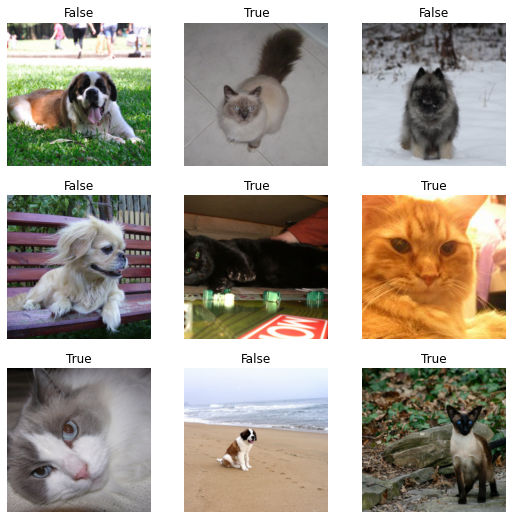

In [ ]:
dls = ImageDataLoaders.from_name_func(path, files, label_func, item_tfms=Resize(224))
dls.show_batch()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

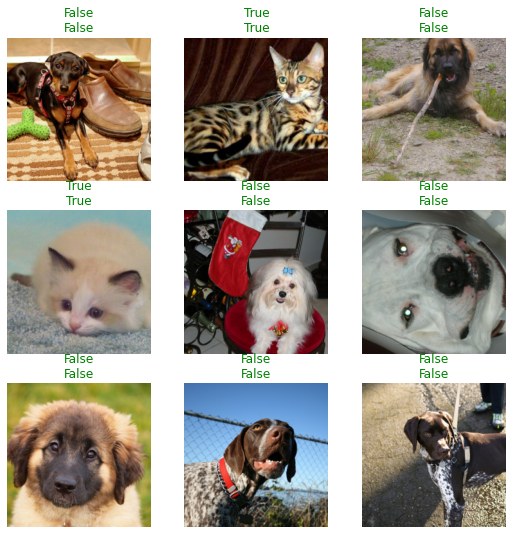

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)
learn.predict(files[0])
learn.show_results()

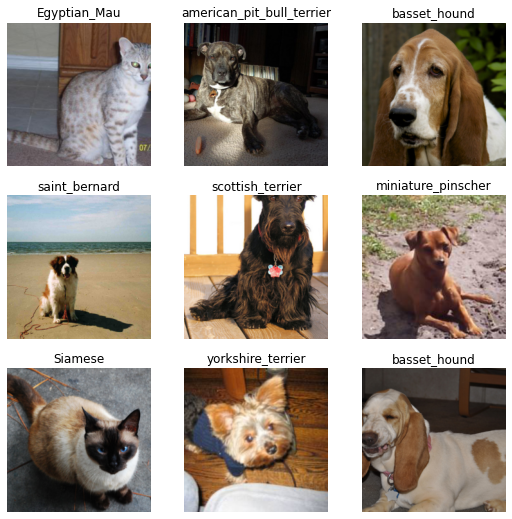

In [ ]:
pat = r'^(.*)_\d+.jpg'
dls = ImageDataLoaders.from_name_re(path, files, pat, item_tfms=Resize(224))
dls.show_batch()

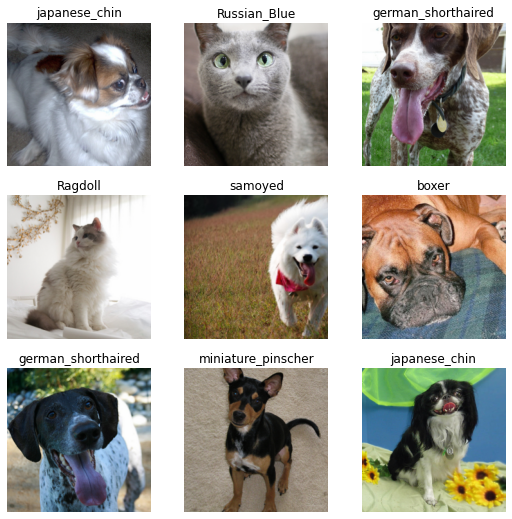

In [ ]:
dls = ImageDataLoaders.from_name_re(path, files, pat, item_tfms=Resize(460),
                                    batch_tfms=aug_transforms(size=224))
dls.show_batch()

SuggestedLRs(valley=0.0004786300996784121)

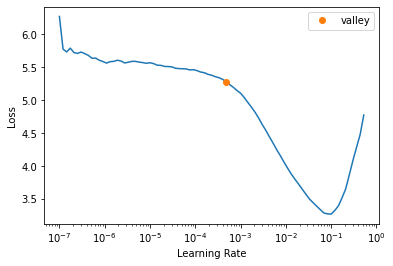

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.lr_find()

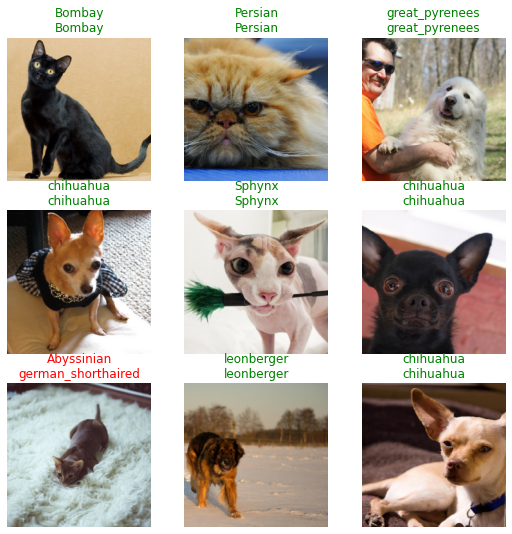

In [ ]:
learn.fine_tune(2, 3e-3)
learn.show_results()

**###Creating a Interpretation Object**

In [ ]:
interp = Interpretation.from_learner(learn)

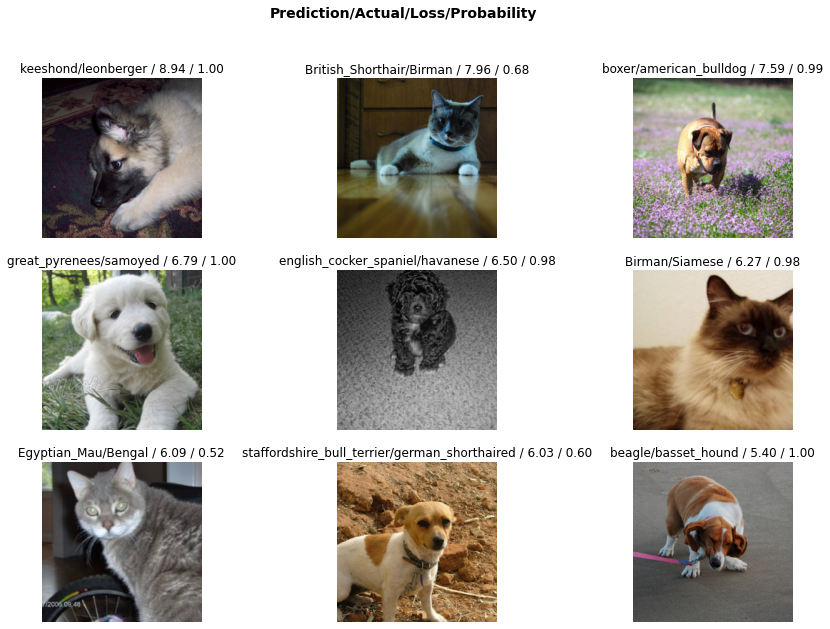

In [ ]:
interp.plot_top_losses(9, figsize=(15,10))

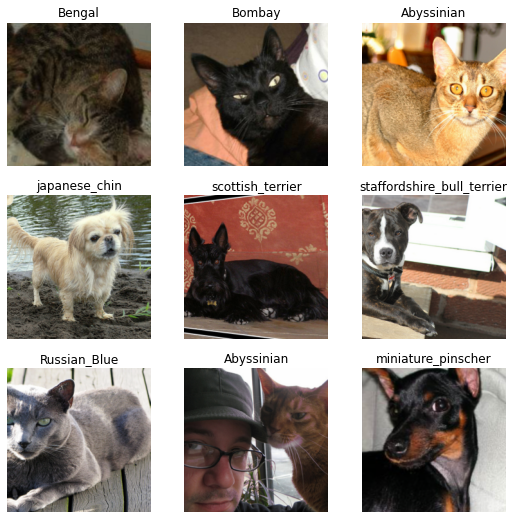

In [ ]:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files, 
                 splitter=RandomSplitter(),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224))
dls = pets.dataloaders(untar_data(URLs.PETS)/"images")
dls.show_batch(max_n=9)

***##Segmentation***

In [ ]:
path = untar_data(URLs.CAMVID_TINY)
path.ls()

(#3) [Path('/root/.fastai/data/camvid_tiny/codes.txt'),Path('/root/.fastai/data/camvid_tiny/labels'),Path('/root/.fastai/data/camvid_tiny/images')]

In [ ]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [ ]:
fnames = get_image_files(path/"images")
fnames[0]

Path('/root/.fastai/data/camvid_tiny/images/Seq05VD_f04950.png')

In [ ]:
(path/"labels").ls()[0]
def label_func(fn): return path/"labels"/f"{fn.stem}_P{fn.suffix}"
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = fnames, label_func = label_func, codes = codes
)

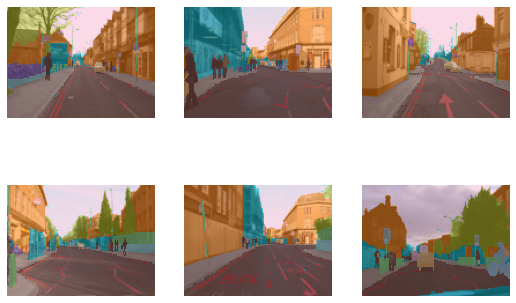

In [ ]:
dls.show_batch(max_n=6)

In [ ]:
learn = unet_learner(dls, resnet34)
learn.fine_tune(6)

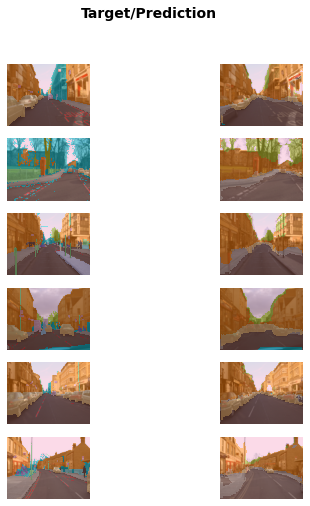

In [ ]:
learn.show_results(max_n=6, figsize=(7,8))

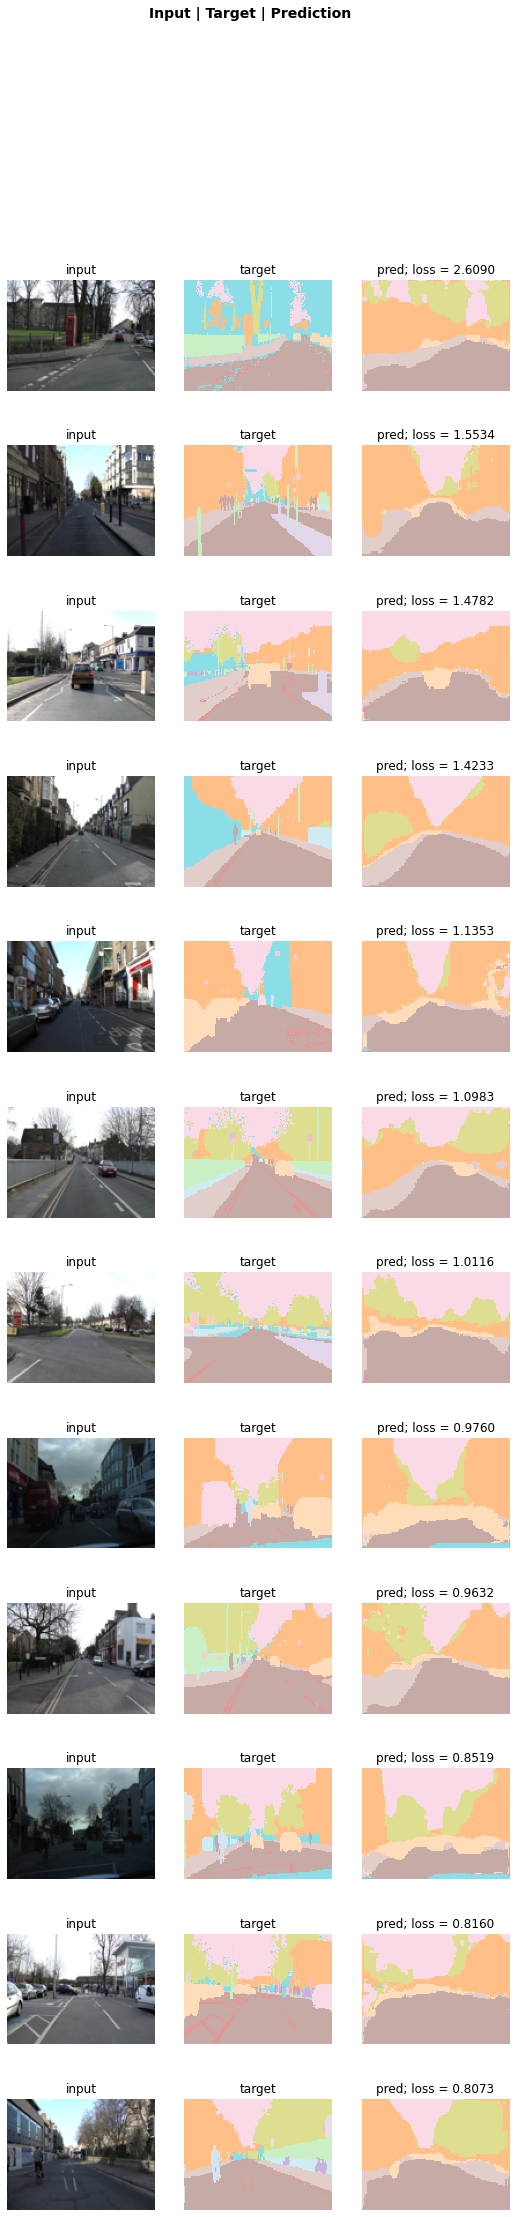

In [ ]:
interp = SegmentationInterpretation.from_learner(learn)
interp.plot_top_losses(k=12)

**##Sentiment Analysis**

In [ ]:
from fastai.text.all import *

In [ ]:
path = untar_data(URLs.IMDB)
path.ls()

(#7) [Path('/root/.fastai/data/imdb/tmp_clas'),Path('/root/.fastai/data/imdb/tmp_lm'),Path('/root/.fastai/data/imdb/train'),Path('/root/.fastai/data/imdb/imdb.vocab'),Path('/root/.fastai/data/imdb/test'),Path('/root/.fastai/data/imdb/README'),Path('/root/.fastai/data/imdb/unsup')]

In [ ]:
(path/'train').ls()

(#4) [Path('/root/.fastai/data/imdb/train/neg'),Path('/root/.fastai/data/imdb/train/labeledBow.feat'),Path('/root/.fastai/data/imdb/train/unsupBow.feat'),Path('/root/.fastai/data/imdb/train/pos')]

In [ ]:
dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test')
dls.show_batch()

### Training the Model

In [ ]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
learn.fine_tune(4, 1e-2)

In [ ]:
learn.show_results()

In [ ]:
learn.predict("I really liked that movie!")

('pos', tensor(1), tensor([0.0036, 0.9964]))

### Fine Tuning

In [ ]:
dls_lm = TextDataLoaders.from_folder(path, is_lm=True, valid_pct=0.1)

In [ ]:
dls_lm.show_batch(max_n=5)

In [ ]:
learn = language_model_learner(dls_lm, AWD_LSTM, metrics=[accuracy, Perplexity()], path=path, wd=0.1).to_fp16()

In [ ]:
learn.fit_one_cycle(1, 1e-2)

In [ ]:
learn.save('1epoch')

Path('/root/.fastai/data/imdb/models/1epoch.pth')

In [ ]:
learn = learn.load('1epoch')
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3)

***## Tabular Learner***

In [ ]:
from fastai.tabular.all import *

In [ ]:
path = untar_data(URLs.ADULT_SAMPLE)
path.ls()

(#3) [Path('/root/.fastai/data/adult_sample/adult.csv'),Path('/root/.fastai/data/adult_sample/export.pkl'),Path('/root/.fastai/data/adult_sample/models')]

In [ ]:
df = pd.read_csv(path/'adult.csv')
df.head()

age          workclass  fnlwgt     education  education-num  \
0   49            Private  101320    Assoc-acdm           12.0   
1   44            Private  236746       Masters           14.0   
2   38            Private   96185       HS-grad            NaN   
3   38       Self-emp-inc  112847   Prof-school           15.0   
4   42   Self-emp-not-inc   82297       7th-8th            NaN   

        marital-status        occupation    relationship                 race  \
0   Married-civ-spouse               NaN            Wife                White   
1             Divorced   Exec-managerial   Not-in-family                White   
2             Divorced               NaN       Unmarried                Black   
3   Married-civ-spouse    Prof-specialty         Husband   Asian-Pac-Islander   
4   Married-civ-spouse     Other-service            Wife                Black   

       sex  capital-gain  capital-loss  hours-per-week  native-country salary  
0   Female             0          1902              40   United-States  >=50k  
1     Male         10520             0              45   United-States  >=50k  
2   Female             0             0              32   United-States   <50k  
3     Male             0             0              40   United-States  >=50k  
4   Female             0             0              50   United-States   <50k

### Splitting Dataset

In [ ]:
dls = TabularDataLoaders.from_csv(path/'adult.csv', path=path, y_names="salary",
    cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race'],
    cont_names = ['age', 'fnlwgt', 'education-num'],
    procs = [Categorify, FillMissing, Normalize])

In [ ]:
splits = RandomSplitter(valid_pct=0.2)(range_of(df))

In [ ]:
to = TabularPandas(df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race'],
                   cont_names = ['age', 'fnlwgt', 'education-num'],
                   y_names='salary',
                   splits=splits)

In [ ]:
to.xs.iloc[:2]

workclass  education  marital-status  occupation  relationship  race  \
9002           5         16               5           5             3     5   
17005          5          3               5           7             4     5   

       education-num_na       age    fnlwgt  education-num  
9002                  1 -0.996461 -0.107327      -0.032360  
17005                 1 -1.583493 -1.518774      -0.816868

In [ ]:
dls = to.dataloaders(bs=64)
dls.show_batch()

### Training the Model

In [ ]:
learn = tabular_learner(dls, metrics=accuracy)

In [ ]:
learn.fit_one_cycle(1)
learn.show_results()

In [ ]:
test_df = df.copy()
test_df.drop(['salary'], axis=1, inplace=True)
dl = learn.dls.test_dl(test_df)

In [ ]:
learn.get_preds(dl=dl)

(tensor([[0.4146, 0.5854],
         [0.5344, 0.4656],
         [0.9254, 0.0746],
         ...,
         [0.6303, 0.3697],
         [0.7411, 0.2589],
         [0.6608, 0.3392]]), None)

## Collabrative Filtering

In [ ]:
from fastai.tabular.all import *
from fastai.collab import *

In [ ]:
path = untar_data(URLs.ML_100k)
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      usecols=(0,1,2), names=['user','movie','rating'])
ratings.head()

user  movie  rating
0   196    242       3
1   186    302       3
2    22    377       1
3   244     51       2
4   166    346       1

In [ ]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

movie              title
0      1   Toy Story (1995)
1      2   GoldenEye (1995)
2      3  Four Rooms (1995)
3      4  Get Shorty (1995)
4      5     Copycat (1995)

In [ ]:
ratings = ratings.merge(movies)
ratings.head()

user  movie  rating         title
0   196    242       3  Kolya (1996)
1    63    242       3  Kolya (1996)
2   226    242       5  Kolya (1996)
3   154    242       3  Kolya (1996)
4   306    242       5  Kolya (1996)

### Training Model

In [ ]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

In [ ]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))
learn.fit_one_cycle(5, 5e-3, wd=0.1)

### Interpretation

In [ ]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)',
       'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)',
       'Air Force One (1997)', 'Independence Day (ID4) (1996)'],
      dtype=object)

### Bias

In [ ]:
movie_bias = learn.model.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [ ]:
mean_ratings = ratings.groupby('title')['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [ ]:
item0 = lambda o:o[0]
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.2869),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.2857), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2776),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2566), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2535), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2525), 'Hellraiser: Bloodline (1996)', 2.0),
 (tensor(-0.2515), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2239), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2180), 'Speed 2: Cruise Control (1997)', 2.1315789473684212),
 (tensor(-0.2118), 'Home Alone 3 (1997)', 1.894736842105263),
 (tensor(-0.2114),
  'Tales from the Crypt Presents: Bordello of Blood (1996)',
  2.6363636363636362),
 (tensor(-0.2065), 'Tales from the Hood (1995)', 2.037037037037037),
 (tensor(-0.1954), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.1939), "Stephen King's The Lang

### Weights

In [ ]:
movie_w = learn.model.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 50])

In [ ]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [ ]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

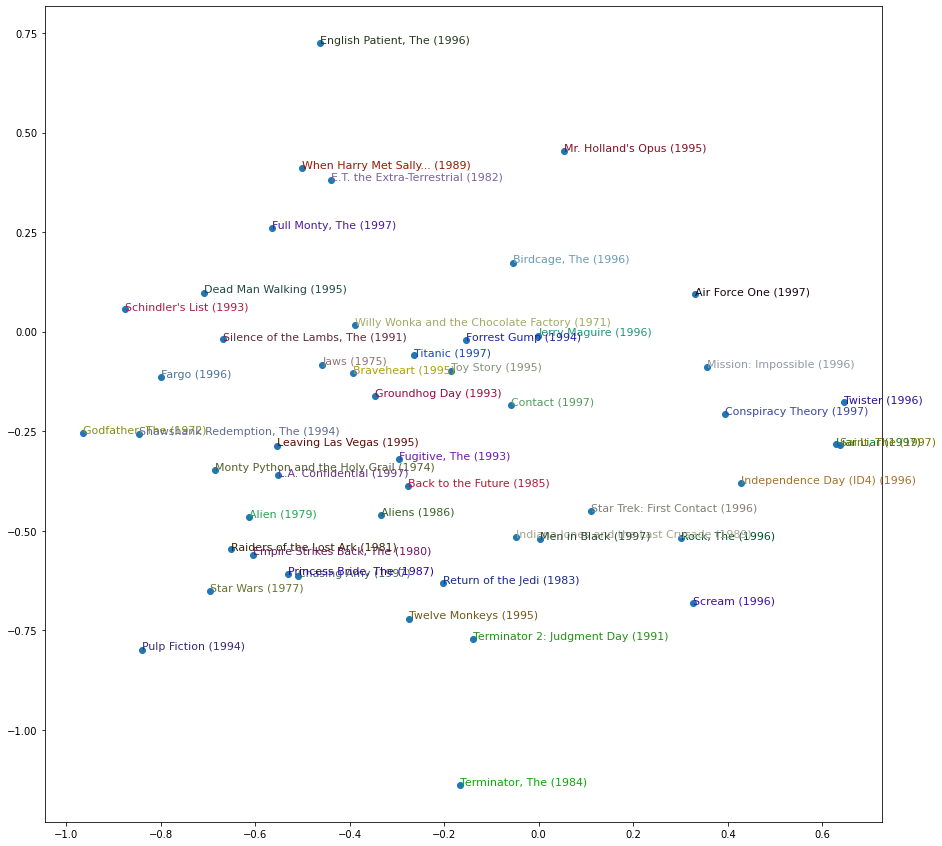

In [ ]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()